# Chapter 8
# Tree- Based Methods

Tree based methods involves stratifying or segmenting the predictor space into a no. of simple regions. To make a prediction, means or mode of training observations is used in the region it belongs.

Since the splitting rules can be summarized in a tree, these approches are called __decision tree methods.__

## Regression Trees
It consists of a series of splitting rules starting at the top of tree. For 2 variable $X_1$ and $X_2$(continous).

In [13]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
import re
import graphviz
import pydotplus
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence

In [90]:
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Hitters.csv"
Hitters = pd.read_csv(url)
Hitters = Hitters[Hitters["Salary"].isna() == False]
Hitters.shape

(263, 20)

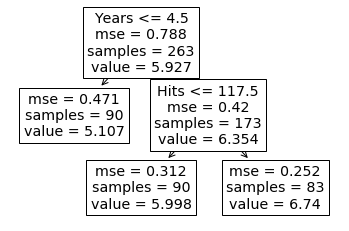

In [7]:
X = np.array(Hitters[["Years","Hits"]])
y = np.array(np.log(Hitters.Salary)).reshape(-1,1)
DT_model = DecisionTreeRegressor(random_state = 0, max_depth = 2, min_samples_leaf = 50).fit(X,y)
plot_tree(DT_model, feature_names = ["Years","Hits"])
plt.show()

Here, the tree has created 3 different segments.

$R_1$ = {X | Years <= 4.5}

$R_2$ = {X | Years > 4.5 and Hits <= 117.5}

$R_3$ = {X | Years > 4.5 and Hits > 117.5}

* These 3 regions are called the _terminal nodes_ or leaves of the tree.
* The point along the tree where the predictor space is split are called the _internal node_.
* Segments of the trees connecting the nodes are called _branches_.

The variable that is used for the split first is the most important variable and the importance decrease as we go down the tree.

Regression trees are the over- simplification of true relationship between X and y but they are easier to interpret and provides a nice graphical representation.

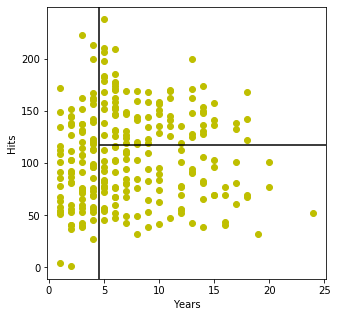

In [8]:
plt.figure(figsize = (5,5))
plt.scatter(Hitters.Years, Hitters.Hits, color = "y")
plt.axvline(x = 4.5, color = "black")
plt.axhline(y = 117.5, xmin = 0.19,color = "black")
plt.xlabel("Years"); plt.ylabel("Hits")
plt.show()

The above chart shows the 4 different region created by the decision tree above.

__Prediction and Stratification of feature space__
1. Divide the predictor space - i.e. the set of possible values for $X_1$, $X_2$ ,...., $X_p$ into J distinct and non-overlapping regions $R_1$, $R_2$,...,$R_J$.
2. For every observation that fall into regions $R_j$, we make same prediction (mean of the response value).

How to select the regions in step 1?

In theory, the regions could have any shape. However, we choose to divide into high dimensional rectangles. Goal is to find these boxes $R_1$, $R_2$,...,$R_J$ that minimizes the RSS given by 
$$\sum_{j = 1}^{J}\sum_{i\epsilon R_j}(y_i - \hat y_{R_j})^2$$
where $\hat y_{R_j}$ = mean response for training observations within $j^{th}$ box.

Considering all possible boxes is infeasible. We use greedy approach called __recursive binary splitting.__

It is greedy because at each step of tree-building process, the best split is made at that particular step, rather than looking ahead and picking a split that will lead to a better tree in some futher step.

__Recursive Binary Splitting__ :- Select $X_j$ and the cutpoint s such that splitting the predictor space into regions {X| $X_j$ < s} and {X| $X_j \ge$ s} leads to greatest rejection in RSS.

For any j and s, we define the pair of half planes as 
$$R_1(j,s) = {X| X_j < s}\ \ and\ \ R_2(j,s) = {X| X_j \ge s}$$
and we seek the value of j and s that minimizes the equation
$$\sum_{i:x_i\epsilon R_1(j,s)}(y_i - \hat y_{R_1})^2 + \sum_{i:x_i\epsilon R_2(j,s)}(y_i - \hat y_{R_2})^2$$
where $\hat y_{R_1}$ is the mean response for the training observations in $R_1(j,s)$ and $\hat y_{R_2}$ is mean response for $R_2(j,s)$.

Then, we repeat the same process but in one of these 2 regions instead of the original predictor space. The process continues until a stopping criteria is reached.

Once the region $R_1$,...,$R_J$ have been created, we perdict the response for a given test observation using the mean of training observation from that region.

__Tree Pruning__ :- If we let the tree grow without restriction, it will become too complex and overfit the data.
* Build tree only so long as the decrease in the RSS due to each split exceeds some threshold. Disadvantage of this method is that we might miss a good split that has about to come after few splits.
* Another method is to grow a very large tree $T_o$ and then prune it back to a subtree.

Our goal is to select a subtree that leads to the lowest test error rate (we can use cross  validation) but CV for each possible subtree would be too cumbersome. To overcome that, we use Cost Complexity pruning (also called the weakest link pruning).

__Cost Complexity Pruning__ :- Rather than considering every subtree, consider a sequence of trees indexed by a non-negative tuning parameter $\alpha$. For each value of $\alpha$ there corresponds a subtree $T \subset T_o$ such that
$$\sum_{m = 1}^{|T|} \sum_{i:x_i\epsilon R_m}(y_i - \hat y_{R_m})^2 + \alpha |T|$$ is as small as possible.

|T| = no. of terminal nodes.

$R_m$ = rectangle corresponding to $m^{th}$ terminal nodes.

$\alpha$ = controls the trade off between the subtree's complexity and its fit to the training data. If $\alpha$ = 0, then the subtree T will simply equal to $T_o$. As $\alpha$ increase, tree gets shorter.

__Steps to build a regression tree__:-
1. Use recursive binary splitting to grow a large tree on training data, stopping only when each terminal node has fewer than some minimum number of observation.
2. Apply cost complexity pruning to the large tree in order to obtain a sequence of best subtree, as a function of $\alpha$.
3. Use k-fold cross validation to choose $\alpha$.
4. Return the subtree from Step 2 that corresponds to the choosen tree.

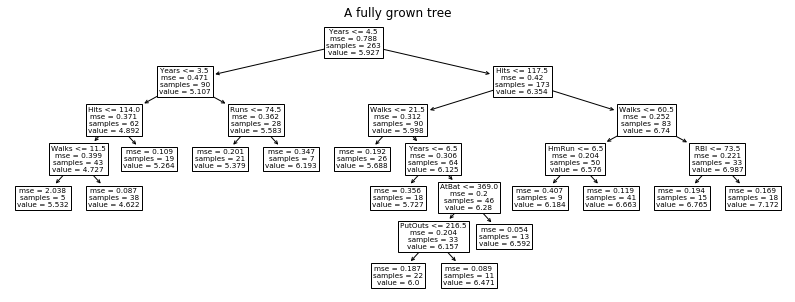

In [65]:
columns = Hitters.select_dtypes(exclude = "object").drop("Salary", axis = 1).columns
var_list_rm_C = [x for x in columns if re.search('^C', x) is None]
X = np.array(Hitters[var_list_rm_C])
y = np.array(np.log(Hitters.Salary)).reshape(-1,1)
DT_model = DecisionTreeRegressor(random_state = 0, min_samples_leaf = 5, min_impurity_decrease = 0.005).fit(X,y)
plt.figure(figsize = (14,5))
plot_tree(DT_model, feature_names = var_list_rm_C)
plt.title("A fully grown tree")
plt.show()

## Classification Trees
To predict a qualitative response.
* We predict that each observation belongs to the most commonly occuring class of training observations in the region to which it belongs.
* We also calculate class proportions among training observations that falls in that regions.
* Instead of using RSS as a criterion for making the binary splits, a natural alternative to RSS is classification error rate(fraction of training observations in that region that do not belongs to most comkon class).
$$E = 1 - max_K(\hat p_{mk})$$
$\hat p_{mk}$ = proportion of training observation in $m^{th}$ region that are from the $k^{th}$ class.

Classification error is not suficiently sensitive for tree growing. Gini Index $$G = \sum_{k = 1}^{K} \hat p_{mk} (1- \hat p_{mk})$$
This is the measure of total varaince across the K classes.

If $\hat p_{mk}$ are close to zero or one, Gini takes on a small value (also called measure of node purity). Small value indicates that a node contains predominantly observation from a single class.

Another alternative is entropy $$D = -\sum_{k=1}^{K}\hat p_{mk}log\hat p_{mk},\ \ \ 0\le -\hat p_{mk}log\hat p_{mk}$$
Entropy take a value near 0 if $\hat p_{mk}$ are all near 0 or near 1.

Gini or entropy can be used to evaluate the quality of a particular split. Classification error rate is preferable if prediction accuracy of the final prune tree is the goal.

__Why node purity is important?__

Node impurity tells us how much incertainity is associated with prediction even if we are predicting same outcome.

In [85]:
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Heart.csv"
Heart = pd.read_csv(url).drop("Unnamed: 0", axis = 1).dropna()
Heart['ChestPain'] = pd.factorize(Heart.ChestPain)[0]
Heart['Thal'] = pd.factorize(Heart.Thal)[0]
Heart.shape

(297, 14)

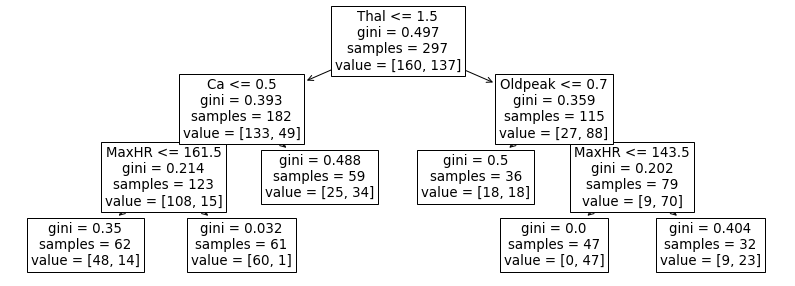

In [103]:
X = Heart.drop("AHD", axis = 1)
y = pd.factorize(Heart.AHD)[0]
DT_model = DecisionTreeClassifier(max_leaf_nodes = 6, min_samples_split = 30, min_samples_leaf = 30).fit(X,y)
plt.figure(figsize = (14,5))
plot_tree(DT_model, feature_names = Heart.drop("AHD", axis = 1).columns)
plt.show()

### Tree versus Linear Model
Linear Regression form $$f(X) = \beta_0 + \sum_{j = 1}^{p}X_j\beta_j$$
whereas regression trees assumes a model of the form $$f(X) = \sum_{m = 1}^{M}c_m * 1_{X\epsilon R_m}$$

If the features and response relationship is non linear and complex then decision tree might outperform classical approaches. Cross validation can also be used to compare these models.

__Advantage and Disadvantages of Trees__:-
* Easier to explain.
* Helps better in decision making.
* can be displayed graphically.
* can handle qualitative predictors without the need to create dummy variable.
* Do not have same level of predictive accuracy as some of the other regression and classification techniques.

## Bagging, Random Forests and Boosting
### Bagging
Decision trees suffer from high variance. Bagging is a general purpose procedure for reducing varaince of a statistical learning method.

__Logic__ :- Given a set of n independent observations $Z_1, Z_2,...,Z_n$ each with variance $\sigma^2$, the variance of mean would be $\sigma^2/n$. Averaging a set of observations reduces variance.

We need to build B models $\hat f^1(x), \hat f^2(x),..., \hat f^B(x)$ using B training sets and average them to get a low variance model.
$$\hat f_{avg}(x) = \frac{1}{B} \sum_{b = 1}^{B}\hat f^b(x)$$
We use bootstrap to create these B samples. It takes repeated samples from the (single) training dataset (with replacement). We will train our method on these b bootstrapeed data $\hat f^{*b}(x)$. and finally average all the prediction.
$$\hat f_{avg}(x) = \frac{1}{B} \sum_{b = 1}^{B}\hat f^{*b}(x)$$
* These trees are grown deep and are not pruned.
* Each tree has low bias and high variance. 
* Averaging them reduces the variance. 

In case of classification trees, one approach is to record class predicted by each tree and take a majority vote.

B (no. of trees) is not critical parameter and using a large value of B will not overfit the data.

__Out-of-Bag Error(OOB) estimation__ :-
We don't need to perform the cross validation to estimate the test error.

* Each bagged tree makes use of around 2/3rd of the observation.
* The remaining 1/3rd observations not included in the training data are called out of bag (OOB) observations.
* We can predict the response for ith observation using each of the trees in which that observation was OOB.
* Each observation will yield B/3 predictions which will be averaged to get one prediction.

OOB error is a valid estimate of test error.

__Variable Importance Measures__:- Bagging trees loses the interpretibility of a decision tree.

But we can obtain an overall summary of the importance of each predictor using the RSS or Gini index. We can record the total amount of RSS decreased due to splits over a given predictor, averaged over all B trees. This average value represents the varaible importance of each varaible. A large value means important predictor.

In classification we look at Gini index and in regression MSE/RSS for the varaible importance.

### Random Forests
Random forest is an improvement over bagged trees by way of a small tweak that decorrelates the trees.
* We will build decision trees on each bootstrapped sample but for each split in these trees we consider only a subset  of predictor(m). A fresh of m predictors are choosen to be considered at each split.
* Typically we choose $m \approx \sqrt p$.
* The logic behind behind this is that if there is a very strong predictor in the dataset, along with other moderate predictors. Then in collection of bagged trees, most of the trees consider this variable for top split and all trees will look quite similar. Hence, the prediction will be correlated and will not lead to a large reduction in variance. In that case, bagging will not lead to a substantial decrease in variance over a single tree.

On an average, a variable will not be considered in (p-m)/p splits and so others variables will have more chance.
This process is called decorrelating the trees.

If m = p, Random forest is bagging trees.

* Using a small value of m will be helpful when we have a large number of coorelated predictors.
* Increasing the value of B, will not overfit.

### Boosting
Boosting works in a similar way as bagging except the trees are grown sequentially. Each tree is grown using information from previously grown tree.

* Boosting does not involve bootstrap sampling, but on a modified version of the original dataset.

__Boosting Algorithm__ :-
1. Set $\hat f(X)$ = 0 and $r_i = y_i$ for all i in training set.
2. For b = 1,2,...,B, repeat:

    (a). Fit a tree $f^b$ with d splits (d+1 terminal nodes) to the training data (X,r).
    
    (b). Update $\hat f$ by adding in a shrunken version of the new tree $$\hat f(x) = \hat f(x) + \lambda \hat f^b(x)$$
    
    (c). Update the residuals $$r_i = r_i - \lambda \hat f^b(x)$$

3. Output the boosted model:
$$\hat f(x) = \sum_{b = 1}^{B}\lambda \hat f^b(x)$$

Boosting approach learn slowly instead of fitting 1 tree and potentially overfit. Given the current model, we fit a decision tree to the residual from the model rather than the outcome Y. We then add it to the fitted function and update the residuals.

* Each of the tree can be small, determined by the paramter d in the algorithm.

By fitting smaller trees, we slowly improve $\hat f$ in areas where it does not perform well. $\lambda$ slows down the process further allowing more and different shaped trees to attack residuals. Construction of each tree depends strongly on the tree that have already been grown.

Boosting has 3 paramters:-
1. B = no. of trees. Unlike bagging boosting can overfit if B is too large, although this overfiting tends to occur slowly if at all.
2. $\lambda$ = a small positive number. This controls the rate at which boosting learns. Typical values are 0.01 and 0.001. Very small $\lambda$ can require a very large B to achieve good performance.
3. d = no. of splits in each tree, which controls the complexity of boosted ensemble. Often d = 1 works well, tree is a stump.
In this case, the boosted ensemble is fitting an additive model, since each term invloves only a single variable.

More generally d is the interaction depth and controls the interaction order of the boosted model, since d splits can involve at most d variable.

For boosting trees, small trees are sufficient.

## Lab: Decision Trees
### Classification Tree

In [4]:
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Carseats.csv"
Carseats = pd.read_csv(url)
Carseats["High"] = "No"
Carseats.loc[Carseats["Sales"] > 8, "High"] = "Yes"
Carseats["ShelveLoc"] = pd.factorize(Carseats.ShelveLoc)[0]
Carseats["Urban"] = pd.factorize(Carseats.Urban)[0]
Carseats["US"] = pd.factorize(Carseats.US)[0]
Carseats["High"].value_counts()

No     236
Yes    164
Name: High, dtype: int64

In [5]:
X = Carseats.drop(["High","Sales"], axis = 1)
y = pd.factorize(Carseats.High)[0]
DT_clf = DecisionTreeClassifier(min_samples_split = 5, min_samples_leaf = 5, max_leaf_nodes = 27).fit(X,y)
print(confusion_matrix(y, DT_clf.predict(X)))
print(classification_report(y, DT_clf.predict(X)))
print("Misclassification Rate:- ", accuracy_score(y, DT_clf.predict(X)))

[[145  19]
 [ 21 215]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       164
           1       0.92      0.91      0.91       236

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400

Misclassification Rate:-  0.9


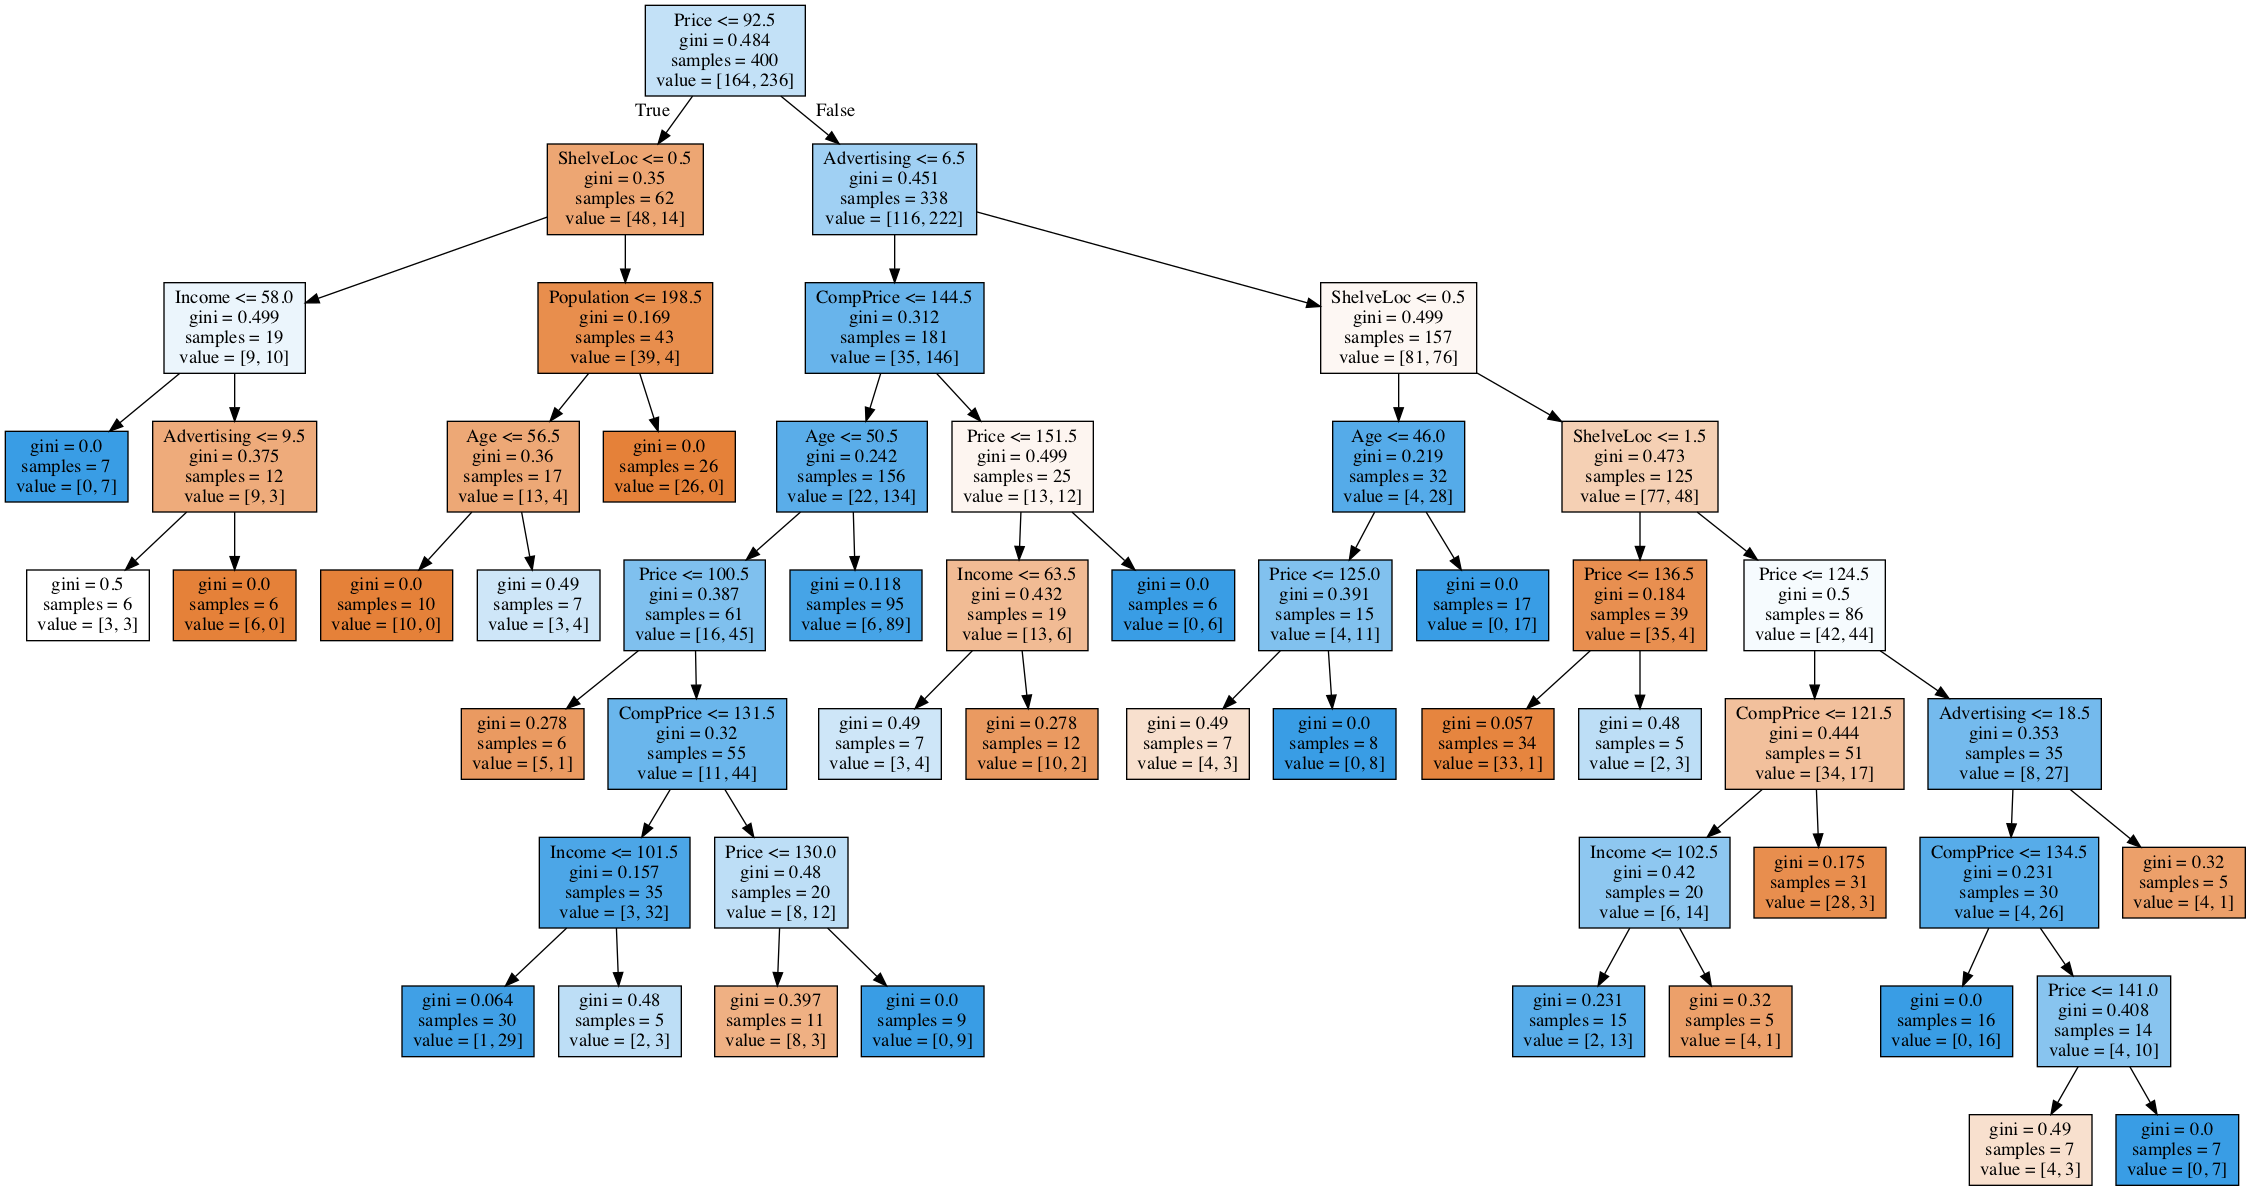

In [6]:
# Function to display decision tree
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = export_graphviz(estimator, out_file=None, feature_names=features, class_names=classn, filled=True)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    return(pydot_graph)
graph = print_tree(DT_clf, features=Carseats.drop(["High","Sales"], axis = 1).columns)
Image(graph.create_png())

In [11]:
# Validation set approach
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)
DT_clf = DecisionTreeClassifier(min_samples_split = 5, min_samples_leaf = 5, max_leaf_nodes = 27).fit(X_train,y_train)
print(confusion_matrix(y_test, DT_clf.predict(X_test)))
print("Misclassification Rate:- ", accuracy_score(y_test, DT_clf.predict(X_test)))

[[54 28]
 [25 93]]
Misclassification Rate:-  0.735


Cost complexity tree pruning is removed from scikit learn.

## Regression Tree

In [3]:
# Loading Boston dataset from sklearn.datasets
boston_dataset = load_boston()
Boston = pd.DataFrame(boston_dataset.data, columns = boston_dataset.feature_names)
# to get an output like R in python, we will use statsmodel instead of sklearn
Boston['MEDV'] = boston_dataset.target
Boston.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [4]:
X = Boston.drop("MEDV", axis = 1)
y = Boston["MEDV"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)

DT_reg = DecisionTreeRegressor(max_depth = 3).fit(X_train, y_train)
print(r2_score(y_test, DT_reg.predict(X_test)))
print(mean_squared_error(y_test, DT_reg.predict(X_test)))

0.6567545227706458
26.02323085009745


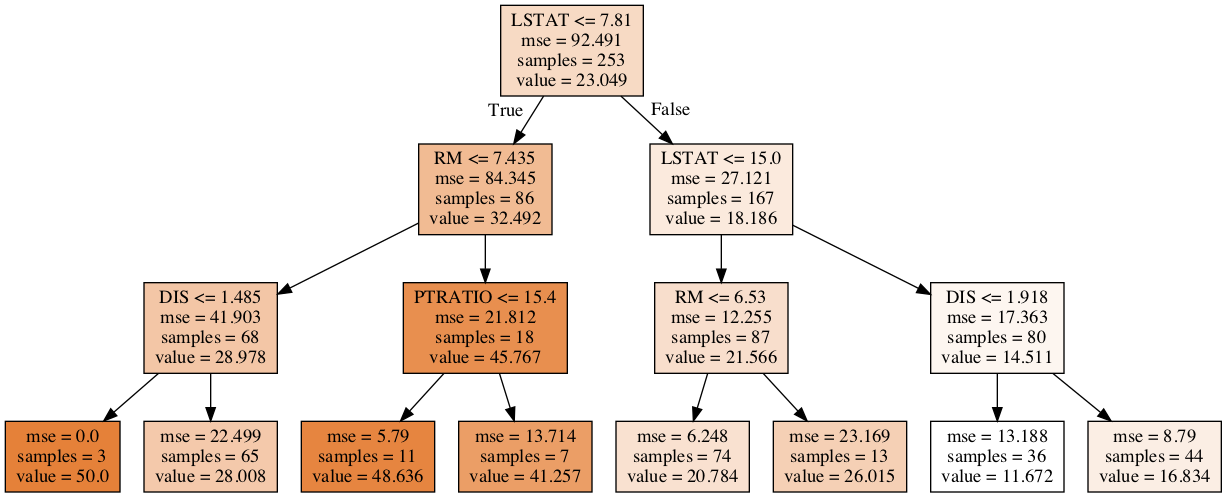

In [29]:
graph = print_tree(DT_reg, features=Boston.drop("MEDV", axis = 1).columns)
Image(graph.create_png())

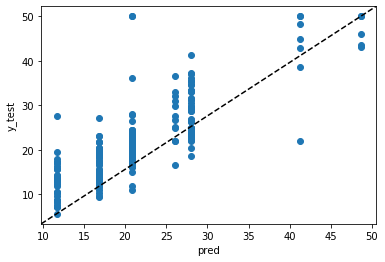

In [28]:
plt.scatter(DT_reg.predict(X_test), y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')
plt.show()

### Bagging and Random Forests

Bagging is the special case of random forest (m = p).

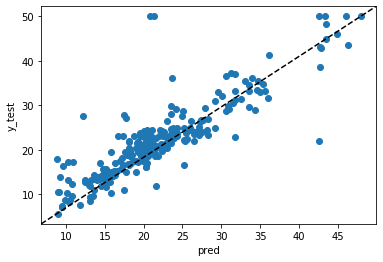

In [118]:
RF_reg = RandomForestRegressor(n_estimators = 500, max_features = 13,
                               min_samples_leaf = 5, min_samples_split = 5,
                               random_state = 1).fit(X_train, y_train)
plt.scatter(RF_reg.predict(X_test), y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')
plt.show()

In [119]:
print(mean_squared_error(y_test, RF_reg.predict(X_test)))
print(r2_score(y_test, RF_reg.predict(X_test)))

18.38321381631009
0.7575260721569864


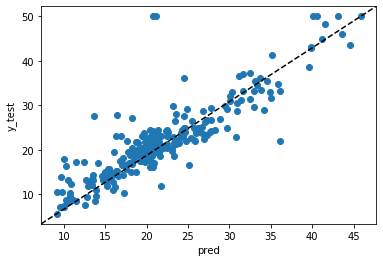

In [128]:
RF_reg = RandomForestRegressor(n_estimators = 100, max_features = 6,
                               min_samples_leaf = 5, min_samples_split = 5,
                               random_state = 1).fit(X_train, y_train)
plt.scatter(RF_reg.predict(X_test), y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')
plt.show()

In [129]:
print(mean_squared_error(y_test, RF_reg.predict(X_test)))
print(r2_score(y_test, RF_reg.predict(X_test)))

17.975269709491332
0.7629068402266583


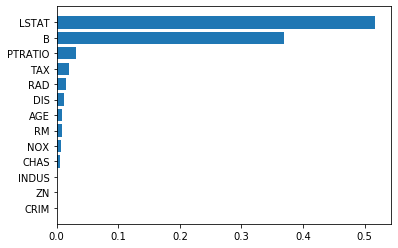

In [130]:
Importance = pd.DataFrame({'Importance':RF_reg.feature_importances_}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True)
plt.barh(list(range(len(importance))), importance)
plt.yticks(list(range(len(importance))), Importance.index)
plt.show()

### Boosting 

In [48]:
Boost_reg = GradientBoostingRegressor(n_estimators = 5000, max_depth = 4,
                                   random_state = 1).fit(X_train, y_train)

Importance = pd.DataFrame({'Importance':Boost_reg.feature_importances_}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=False)

,Importance
LSTAT,0.595027
RM,0.227772
DIS,0.074380
PTRATIO,0.031985
CRIM,0.024661
TAX,0.014923
AGE,0.012496
B,0.006819
INDUS,0.005968
NOX,0.002812


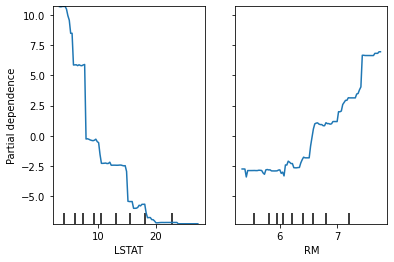

In [50]:
ax = plot_partial_dependence(Boost_reg, X_train, feature_names = Importance.index, features = ["LSTAT","RM"])

In [49]:
print(mean_squared_error(y_test, Boost_reg.predict(X_test)))

17.14310973942672


Not much improvement from the Random Forest. We will try a different learning rate.

In [53]:
Boost_reg = GradientBoostingRegressor(n_estimators = 5000, max_depth = 4, learning_rate = 0.01,
                                   random_state = 1).fit(X_train, y_train)
print(mean_squared_error(y_test, Boost_reg.predict(X_test)))

17.06524570625108
